<a href="https://colab.research.google.com/github/musfikur-rahaman/SoccerAction_SoccerActDataset/blob/main/Video_classification_using_TimeSformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1.Installation of Essential Libraries**

In [ ]:
pip install torch torchvision timm transformers opencv-python pandas scikit-learn numpy tqdm

**2.Imports various Python libraries and modules**

---



In [ ]:
import os
import gc
import cv2
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from transformers import TimesformerForVideoClassification, TimesformerConfig

import matplotlib.pyplot as plt


**3.Mount  Google Drive to the Colab environment**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**4.Loading and Organizing Video Dataset for Action Classification**

In [ ]:
def load_dataset(dataset_path):
    video_paths = []
    labels = []
    class_to_idx = {}

    # Assign an index to each action class
    for idx, action in enumerate(sorted(os.listdir(dataset_path))):
        class_to_idx[action] = idx
        action_path = os.path.join(dataset_path, action)

        if os.path.isdir(action_path):
            for video_file in os.listdir(action_path):
                if video_file.endswith(('.mp4', '.avi', '.mov')):
                    video_paths.append(os.path.join(action_path, video_file))
                    labels.append(idx)

    return video_paths, labels, class_to_idx

dataset_path = "/content/drive/MyDrive/soccer_dataset"
video_paths, labels, class_to_idx = load_dataset(dataset_path)

print(f"Loaded {len(video_paths)} videos from {len(class_to_idx)} classes.")
print("Class labels:", class_to_idx)

Loaded 3610 videos from 10 classes.
Class labels: {'corner': 0, 'foul': 1, 'freekick': 2, 'goalkick': 3, 'longpass': 4, 'ontarget': 5, 'penalty': 6, 'shortpass': 7, 'substitution': 8, 'throw-in': 9}


In [ ]:
train_videos, test_videos, train_labels, test_labels = train_test_split(
    video_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training videos: {len(train_videos)}, Testing videos: {len(test_videos)}")

Training videos: 2888, Testing videos: 722


**5.Custom Dataset Class for Soccer Video Action Classification**

In [ ]:
class SoccerVideoDataset(Dataset):
    def __init__(self, video_paths, labels, transform=None, num_frames=8):
        self.video_paths = video_paths
        self.labels = labels
        self.transform = transform
        self.num_frames = num_frames

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]

        assert os.path.exists(video_path), f"❌ Missing file: {video_path}"
        frames = self.load_video_frames(video_path)

        if self.transform:
            frames = torch.stack([self.transform(frame) for frame in frames])  # Shape: (num_frames, 3, 224, 224)
        else:
            frames = torch.stack(frames)  # Just stack raw frames

        return frames, torch.tensor(label, dtype=torch.long)

    def load_video_frames(self, video_path):
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_indices = np.linspace(0, max(total_frames - 1, 0), self.num_frames).astype(int)
        frames = []

        for idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()

            if not ret:
                print(f"⚠️ Failed to read frame {idx} from {video_path}")
                black_frame = torch.zeros((224, 224, 3), dtype=torch.float32)
                frames.append(black_frame)
                continue

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (224, 224))
            frame = torch.tensor(frame, dtype=torch.float32) / 255.0
            frames.append(frame)

        cap.release()

        while len(frames) < self.num_frames:
            black_frame = torch.zeros((224, 224, 3), dtype=torch.float32)
            frames.append(black_frame)

        return frames


**6.Transformation Pipeline for Preprocessing Soccer Video Frames**

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ensures frames are of correct size
    transforms.ToTensor(),  # Converts NumPy arrays to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])

**7.Soccer Action Video Classification Dataset Preparation**

In [ ]:


# Function to extract frames
def video_to_frames(video_path, num_frames=8):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames-1, num_frames, dtype=int)
    frames = []

    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = transform(frame)
            frames.append(frame)

    cap.release()

    if len(frames) < num_frames:  # Padding if video is too short
        frames.extend([torch.zeros(3, 224, 224)] * (num_frames - len(frames)))

    return torch.stack(frames)  # Shape: (num_frames, 3, 224, 224)

# Custom dataset class
class SoccerDataset(Dataset):
    def __init__(self, root_dir, num_frames=8):
        self.root_dir = root_dir
        self.num_frames = num_frames
        self.video_paths = []
        self.labels = []

        # Load video file paths and labels
        for action in os.listdir(root_dir):
            action_path = os.path.join(root_dir, action)
            if os.path.isdir(action_path):
                for video_file in os.listdir(action_path):
                    if video_file.endswith((".mp4", ".avi", ".mov")):
                        self.video_paths.append(os.path.join(action_path, video_file))
                        self.labels.append(action)

        # Encode labels to numeric values
        self.label_encoder = LabelEncoder()
        self.encoded_labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.encoded_labels[idx]
        frames = video_to_frames(video_path, self.num_frames)

        return frames, torch.tensor(label, dtype=torch.long)

# Load dataset from single folder
dataset_path = "/content/drive/MyDrive/soccer_dataset"
dataset = SoccerDataset(dataset_path)

# Split dataset into Train (70%), Val (15%), Test (15%)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print(f"Dataset loaded: {len(train_dataset)} train, {len(val_dataset)} val, {len(test_dataset)} test.")


Dataset loaded: 2527 train, 541 val, 542 test.


**8.Loading and Modifying Pre-Trained TimeSformer Model for Custom Video Classification**

In [ ]:
import torch
import torch.nn as nn
from transformers import TimesformerConfig, TimesformerForVideoClassification

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the number of classes
num_classes = 10  # Update this for your dataset

# Model name
model_name = "facebook/timesformer-base-finetuned-k400"

# Load configuration
config = TimesformerConfig.from_pretrained(model_name)
config.num_labels = num_classes

# Load pre-trained model
model = TimesformerForVideoClassification.from_pretrained(
    model_name, config=config, ignore_mismatched_sizes=True
)

# 🔽 Replace classifier head with dropout + linear
dropout_rate = 0.3  # You can tune this hyperparameter

model.classifier = nn.Sequential(
    nn.Dropout(p=dropout_rate),
    nn.Linear(config.hidden_size, num_classes)
)

# Move to device
model.to(device)

# Print model summary
print(model)


Some weights of TimesformerForVideoClassification were not initialized from the model checkpoint at facebook/timesformer-base-finetuned-k400 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TimesformerForVideoClassification(
  (timesformer): TimesformerModel(
    (embeddings): TimesformerEmbeddings(
      (patch_embeddings): TimesformerPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (time_drop): Dropout(p=0.0, inplace=False)
    )
    (encoder): TimesformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x TimesformerLayer(
          (drop_path): Identity()
          (attention): TimeSformerAttention(
            (attention): TimesformerSelfAttention(
              (qkv): Linear(in_features=768, out_features=2304, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
            )
            (output): TimesformerSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): TimesformerIntermediate(
            (dense

**9.Convert Video to Preprocessed Frame Tensor for Model Input**

In [ ]:
def video_to_frames(video_path, num_frames=8):
    cap = cv2.VideoCapture(video_path)
    frames = []

    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Ensure correct size
        transforms.ToTensor(),          # Convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])

    for _ in range(num_frames):
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            frame = Image.fromarray(frame)  # Convert NumPy array to PIL Image
            frame = transform(frame)  # Apply transforms
            frames.append(frame)

    cap.release()

    if len(frames) < num_frames:
        # Pad with black frames if video is too short
        empty_frame = torch.zeros((3, 224, 224))
        frames.extend([empty_frame] * (num_frames - len(frames)))

    return torch.stack(frames)  # Stack frames into tensor

**10.Training and Validation Loop for TimeSformer with Mixed Precision and Gradient Clipping**

**Updated Training and Validation**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import gc
from transformers import get_linear_schedule_with_warmup

# Move model to device
model = model.to(device)

# Criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Enable AMP if supported
use_amp = torch.cuda.is_available()
scaler = torch.cuda.amp.GradScaler() if use_amp else None

# Scheduler
num_epochs = 10
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

# Metrics storage
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_precisions, val_recalls, val_f1s = [], [], []
best_val_f1 = 0

for epoch in range(num_epochs):
    print(f"\n🔁 Starting Epoch [{epoch+1}/{num_epochs}]")

    # Training phase
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Training")

    for i, (videos, labels) in enumerate(train_loop):
        videos, labels = videos.to(device), labels.to(device)
        optimizer.zero_grad()

        if i == 0:
            print(f"📊 Input stats: mean={videos.mean().item():.4f}, std={videos.std().item():.4f}")

        with torch.cuda.amp.autocast(enabled=use_amp):
            outputs = model(videos).logits
            loss = criterion(outputs, labels)

            if torch.isnan(loss):
                print("🚨 NaN in training loss!")

        if use_amp:
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        scheduler.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        train_loop.set_postfix(loss=train_loss / (i + 1), acc=100. * correct / total)

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100. * correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    print(f"✅ Epoch [{epoch+1}], Train Loss: {avg_train_loss:.4f}, Acc: {train_accuracy:.2f}%")

    # Validation phase
    model.eval()
    val_loss = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for videos, labels in val_loader:
            videos, labels = videos.to(device), labels.to(device)

            with torch.cuda.amp.autocast(enabled=use_amp):
                outputs = model(videos).logits
                loss = criterion(outputs, labels)

                if torch.isnan(loss):
                    print("🚨 NaN in validation loss!")

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Metrics
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(y_true, y_pred) * 100
    val_precision = precision_score(y_true, y_pred, average='macro', zero_division=0) * 100
    val_recall = recall_score(y_true, y_pred, average='macro', zero_division=0) * 100
    val_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0) * 100

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)

    print(f"📈 Epoch [{epoch+1}], Val Loss: {avg_val_loss:.4f}, Acc: {val_accuracy:.2f}%, Precision: {val_precision:.2f}%, Recall: {val_recall:.2f}%, F1: {val_f1:.2f}%")

    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), f"best_model.pth")
        print(f"💾 Best model saved (F1={val_f1:.2f}%)")

    # Save current epoch model
    torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth")
    print(f"💾 Epoch model saved: model_epoch_{epoch+1}.pth")

    # Clean-up
    torch.cuda.empty_cache()
    gc.collect()


<ipython-input-21-b60c12357bf5>:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None



🔁 Starting Epoch [1/10]


Epoch [1/10] - Training:   0%|          | 0/632 [00:00<?, ?it/s]<ipython-input-21-b60c12357bf5>:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
Epoch [1/10] - Training:   0%|          | 1/632 [00:01<16:25,  1.56s/it, acc=0, loss=2.77]

📊 Input stats: mean=-0.2145, std=0.6676


Epoch [1/10] - Training: 100%|██████████| 632/632 [09:09<00:00,  1.15it/s, acc=41.6, loss=1.68]


✅ Epoch [1], Train Loss: 1.6839, Acc: 41.63%


<ipython-input-21-b60c12357bf5>:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


📈 Epoch [1], Val Loss: 0.9709, Acc: 67.65%, Precision: 69.17%, Recall: 67.91%, F1: 66.56%
💾 Best model saved (F1=66.56%)
💾 Epoch model saved: model_epoch_1.pth

🔁 Starting Epoch [2/10]


Epoch [2/10] - Training:   0%|          | 0/632 [00:00<?, ?it/s]<ipython-input-21-b60c12357bf5>:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
Epoch [2/10] - Training:   0%|          | 1/632 [00:00<04:36,  2.28it/s, acc=100, loss=0.602]

📊 Input stats: mean=-0.0427, std=0.8209


Epoch [2/10] - Training: 100%|██████████| 632/632 [04:48<00:00,  2.19it/s, acc=78.6, loss=0.611]


✅ Epoch [2], Train Loss: 0.6113, Acc: 78.59%


<ipython-input-21-b60c12357bf5>:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


📈 Epoch [2], Val Loss: 0.5627, Acc: 82.44%, Precision: 84.54%, Recall: 82.35%, F1: 82.36%
💾 Best model saved (F1=82.36%)
💾 Epoch model saved: model_epoch_2.pth

🔁 Starting Epoch [3/10]


Epoch [3/10] - Training:   0%|          | 0/632 [00:00<?, ?it/s]<ipython-input-21-b60c12357bf5>:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
Epoch [3/10] - Training:   0%|          | 1/632 [00:00<04:33,  2.31it/s, acc=100, loss=0.0226]

📊 Input stats: mean=-0.3562, std=0.9211


Epoch [3/10] - Training: 100%|██████████| 632/632 [04:52<00:00,  2.16it/s, acc=92.6, loss=0.245]


✅ Epoch [3], Train Loss: 0.2447, Acc: 92.64%


<ipython-input-21-b60c12357bf5>:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


📈 Epoch [3], Val Loss: 0.4792, Acc: 87.06%, Precision: 86.68%, Recall: 86.76%, F1: 86.61%
💾 Best model saved (F1=86.61%)
💾 Epoch model saved: model_epoch_3.pth

🔁 Starting Epoch [4/10]


Epoch [4/10] - Training:   0%|          | 0/632 [00:00<?, ?it/s]<ipython-input-21-b60c12357bf5>:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
Epoch [4/10] - Training:   0%|          | 1/632 [00:00<04:41,  2.24it/s, acc=100, loss=0.000196]

📊 Input stats: mean=-0.2504, std=0.8601


Epoch [4/10] - Training: 100%|██████████| 632/632 [04:48<00:00,  2.19it/s, acc=96, loss=0.179]


✅ Epoch [4], Train Loss: 0.1793, Acc: 95.96%


<ipython-input-21-b60c12357bf5>:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


📈 Epoch [4], Val Loss: 0.6964, Acc: 89.65%, Precision: 89.96%, Recall: 89.17%, F1: 89.30%
💾 Best model saved (F1=89.30%)
💾 Epoch model saved: model_epoch_4.pth

🔁 Starting Epoch [5/10]


Epoch [5/10] - Training:   0%|          | 0/632 [00:00<?, ?it/s]<ipython-input-21-b60c12357bf5>:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
Epoch [5/10] - Training:   0%|          | 1/632 [00:00<08:09,  1.29it/s, acc=100, loss=3.34e-6]

📊 Input stats: mean=-0.2087, std=0.7399


Epoch [5/10] - Training: 100%|██████████| 632/632 [04:42<00:00,  2.24it/s, acc=99, loss=0.0745]


✅ Epoch [5], Train Loss: 0.0745, Acc: 98.97%


<ipython-input-21-b60c12357bf5>:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


📈 Epoch [5], Val Loss: 0.7304, Acc: 90.94%, Precision: 91.13%, Recall: 90.65%, F1: 90.62%
💾 Best model saved (F1=90.62%)
💾 Epoch model saved: model_epoch_5.pth

🔁 Starting Epoch [6/10]


Epoch [6/10] - Training:   0%|          | 0/632 [00:00<?, ?it/s]<ipython-input-21-b60c12357bf5>:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
Epoch [6/10] - Training:   0%|          | 1/632 [00:00<04:38,  2.27it/s, acc=100, loss=1.64e-6]

📊 Input stats: mean=-0.2628, std=0.7023


Epoch [6/10] - Training: 100%|██████████| 632/632 [04:46<00:00,  2.20it/s, acc=99.1, loss=0.067]


✅ Epoch [6], Train Loss: 0.0670, Acc: 99.13%


<ipython-input-21-b60c12357bf5>:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


📈 Epoch [6], Val Loss: 1.0126, Acc: 89.09%, Precision: 89.11%, Recall: 89.02%, F1: 88.69%
💾 Epoch model saved: model_epoch_6.pth

🔁 Starting Epoch [7/10]


Epoch [7/10] - Training:   0%|          | 0/632 [00:00<?, ?it/s]<ipython-input-21-b60c12357bf5>:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
Epoch [7/10] - Training:   0%|          | 1/632 [00:00<04:48,  2.19it/s, acc=100, loss=1.07e-6]

📊 Input stats: mean=-0.2981, std=0.6881


Epoch [7/10] - Training: 100%|██████████| 632/632 [04:45<00:00,  2.22it/s, acc=99.8, loss=0.0139]


✅ Epoch [7], Train Loss: 0.0139, Acc: 99.76%


<ipython-input-21-b60c12357bf5>:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


📈 Epoch [7], Val Loss: 0.8029, Acc: 90.20%, Precision: 90.27%, Recall: 90.09%, F1: 89.92%
💾 Epoch model saved: model_epoch_7.pth

🔁 Starting Epoch [8/10]


Epoch [8/10] - Training:   0%|          | 0/632 [00:00<?, ?it/s]<ipython-input-21-b60c12357bf5>:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
Epoch [8/10] - Training:   0%|          | 1/632 [00:00<04:41,  2.24it/s, acc=100, loss=4.17e-7]

📊 Input stats: mean=-0.4673, std=0.8303


Epoch [8/10] - Training: 100%|██████████| 632/632 [04:43<00:00,  2.23it/s, acc=99.8, loss=0.00422]


✅ Epoch [8], Train Loss: 0.0042, Acc: 99.80%


<ipython-input-21-b60c12357bf5>:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


📈 Epoch [8], Val Loss: 0.9252, Acc: 89.83%, Precision: 90.36%, Recall: 89.46%, F1: 89.58%
💾 Epoch model saved: model_epoch_8.pth

🔁 Starting Epoch [9/10]


Epoch [9/10] - Training:   0%|          | 0/632 [00:00<?, ?it/s]<ipython-input-21-b60c12357bf5>:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
Epoch [9/10] - Training:   0%|          | 1/632 [00:00<04:40,  2.25it/s, acc=100, loss=5.36e-7]

📊 Input stats: mean=-0.3731, std=0.6879


Epoch [9/10] - Training: 100%|██████████| 632/632 [04:45<00:00,  2.22it/s, acc=100, loss=0.000178]


✅ Epoch [9], Train Loss: 0.0002, Acc: 100.00%


<ipython-input-21-b60c12357bf5>:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


📈 Epoch [9], Val Loss: 0.7251, Acc: 90.94%, Precision: 90.98%, Recall: 90.65%, F1: 90.59%
💾 Epoch model saved: model_epoch_9.pth

🔁 Starting Epoch [10/10]


Epoch [10/10] - Training:   0%|          | 0/632 [00:00<?, ?it/s]<ipython-input-21-b60c12357bf5>:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
Epoch [10/10] - Training:   0%|          | 1/632 [00:00<04:35,  2.29it/s, acc=100, loss=2.68e-7]

📊 Input stats: mean=-0.2825, std=0.7382


Epoch [10/10] - Training: 100%|██████████| 632/632 [04:46<00:00,  2.21it/s, acc=100, loss=4.69e-7]


✅ Epoch [10], Train Loss: 0.0000, Acc: 100.00%


<ipython-input-21-b60c12357bf5>:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


📈 Epoch [10], Val Loss: 0.7086, Acc: 91.13%, Precision: 91.22%, Recall: 90.85%, F1: 90.81%
💾 Best model saved (F1=90.81%)
💾 Epoch model saved: model_epoch_10.pth


**11.Model Evaluation**

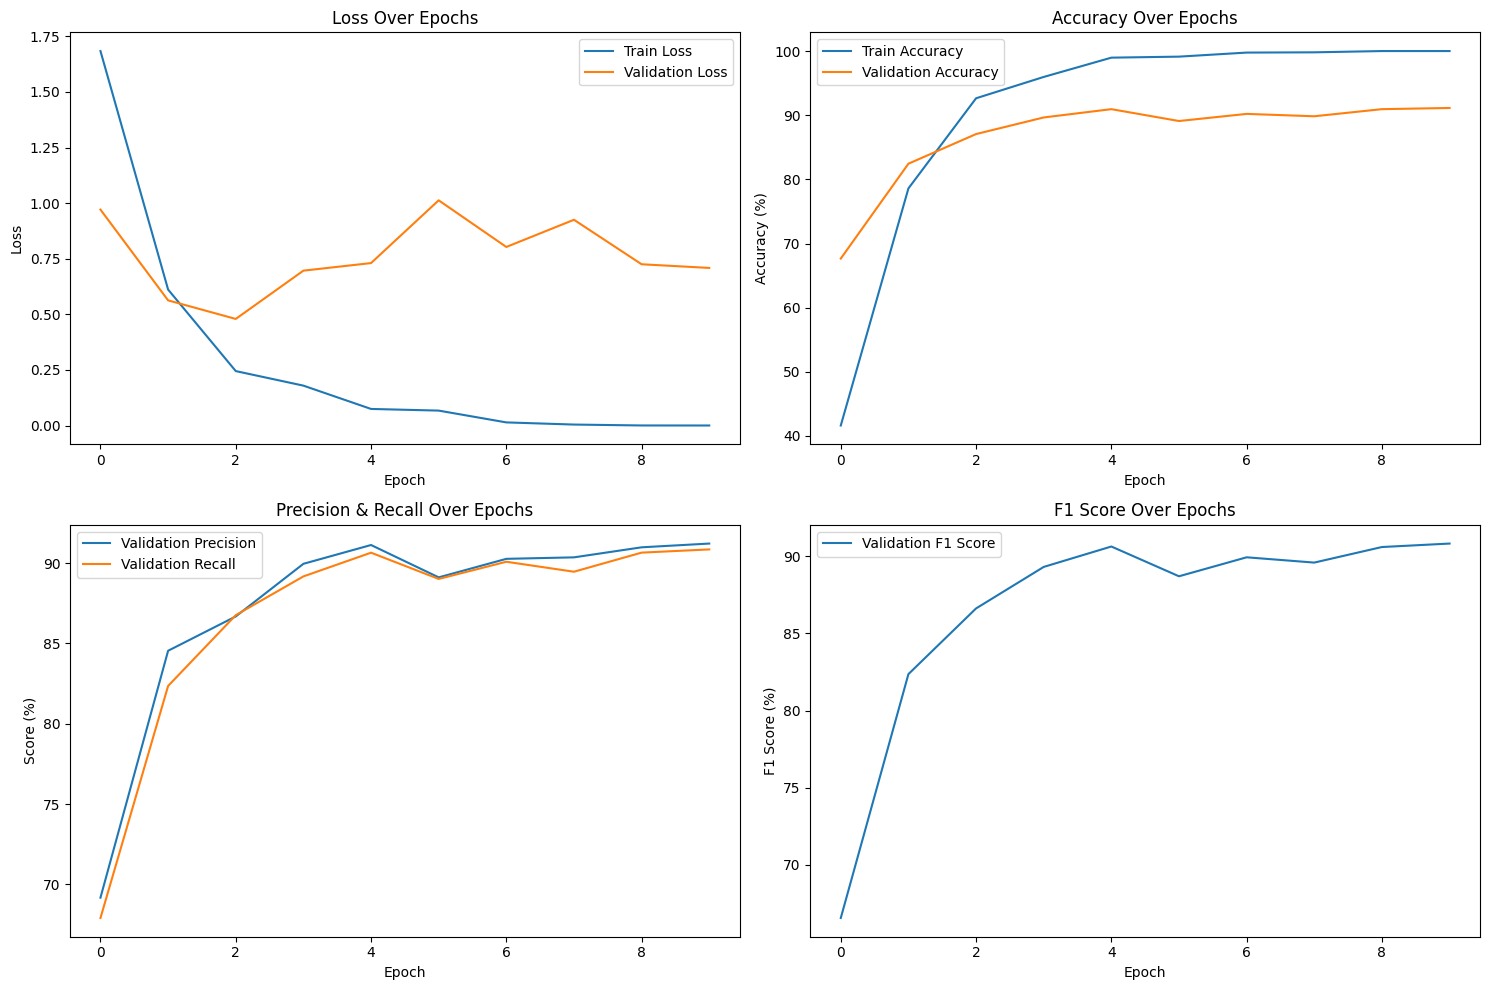


📊 Evaluation Summary:
Accuracy     : 91.13%
Precision    : 91.22%
Recall       : 90.85%
F1 Score     : 90.81%

📝 Classification Report:
              precision    recall  f1-score   support

      corner     0.8689    0.9138    0.8908        58
        foul     0.8611    0.7381    0.7949        42
    freekick     0.9464    0.8548    0.8983        62
    goalkick     0.9655    0.9825    0.9739        57
    longpass     0.7627    0.9375    0.8411        48
    ontarget     0.9531    0.9242    0.9385        66
     penalty     0.9400    1.0000    0.9691        47
   shortpass     0.9773    0.8600    0.9149        50
substitution     0.9615    0.9434    0.9524        53
    throw-in     0.8852    0.9310    0.9076        58

    accuracy                         0.9113       541
   macro avg     0.9122    0.9085    0.9081       541
weighted avg     0.9152    0.9113    0.9112       541



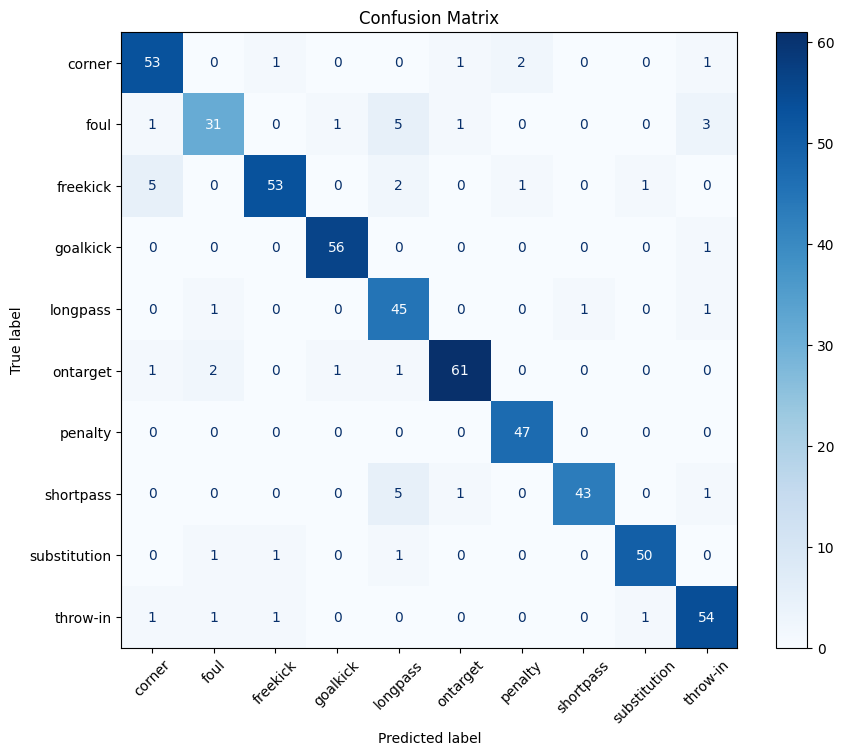

In [ ]:
# Define your class labels
class_labels = ['corner', 'foul', 'freekick', 'goalkick', 'longpass', 'ontarget', 'penalty', 'shortpass', 'substitution', 'throw-in']

def evaluate_model(model, val_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for videos, labels in val_loader:
            videos, labels = videos.to(device), labels.to(device)
            outputs = model(videos).logits
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate all metrics
    acc = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred, average='macro') * 100
    recall = recall_score(y_true, y_pred, average='macro') * 100
    f1 = f1_score(y_true, y_pred, average='macro') * 100

    # Print overall results
    print("\n📊 Evaluation Summary:")
    print(f"Accuracy     : {acc:.2f}%")
    print(f"Precision    : {precision:.2f}%")
    print(f"Recall       : {recall:.2f}%")
    print(f"F1 Score     : {f1:.2f}%")

    # Classification Report (per class metrics)
    print("\n📝 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

# ------------------- FINAL: Plotting Metrics ------------------- #

plt.figure(figsize=(15, 10))

# Loss plot
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Precision/Recall plot
plt.subplot(2, 2, 3)
plt.plot(val_precisions, label='Validation Precision')
plt.plot(val_recalls, label='Validation Recall')
plt.title('Precision & Recall Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score (%)')
plt.legend()

# F1 Score plot
plt.subplot(2, 2, 4)
plt.plot(val_f1s, label='Validation F1 Score')
plt.title('F1 Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score (%)')
plt.legend()

plt.tight_layout()
plt.show()

# ---- Call evaluation AFTER the plots ---- #
evaluate_model(model, val_loader, device)
